In [1]:
import os
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import umap
from notebook_init_utils import bandicoot_check, init_notebook

# plot on PCA and UMAP
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [2]:
root_dir, in_notebook = init_notebook()

image_base_dir = bandicoot_check(
    pathlib.Path(os.path.expanduser("~/mnt/bandicoot")).resolve(), root_dir
)
image_base_dir

PosixPath('/home/lippincm/mnt/bandicoot/NF1_organoid_data')

In [3]:
patient_ids_file_path = pathlib.Path(f"{root_dir}/data/patient_IDs.txt").resolve()
patient_ids = pd.read_csv(patient_ids_file_path, header=None)[0].tolist()

In [4]:
list_of_file_paths = []
for patient in patient_ids:
    whole_image_features_path = pathlib.Path(
        f"{image_base_dir}/data/{patient}/whole_image_features"
    ).resolve()
    if not whole_image_features_path.exists():
        continue

    list_of_file_paths.extend(list(whole_image_features_path.glob("*.parquet")))
print(f"Found {len(list_of_file_paths)} files to combine.")

Found 3720 files to combine.


In [5]:
df = pd.concat(
    [pd.read_parquet(file_path) for file_path in list_of_file_paths],
    ignore_index=True,
)
df.head()

,patient,well_fov,405_CHAMI75_feature_0,405_CHAMI75_feature_1,405_CHAMI75_feature_10,405_CHAMI75_feature_100,405_CHAMI75_feature_101,405_CHAMI75_feature_102,405_CHAMI75_feature_103,405_CHAMI75_feature_104,...,TRANS_SAMMed3D_feature_90,TRANS_SAMMed3D_feature_91,TRANS_SAMMed3D_feature_92,TRANS_SAMMed3D_feature_93,TRANS_SAMMed3D_feature_94,TRANS_SAMMed3D_feature_95,TRANS_SAMMed3D_feature_96,TRANS_SAMMed3D_feature_97,TRANS_SAMMed3D_feature_98,TRANS_SAMMed3D_feature_99
0,NF0014_T1,F11-2,-1.431633,-0.509397,2.533682,-1.656899,5.957388,4.266065,-4.404616,-5.434089,...,-0.005877,-0.128369,-0.096464,-0.011126,0.007365,-0.073447,0.056415,0.147222,0.417246,0.104045
1,NF0014_T1,F10-1,4.869580,-2.873573,3.169348,-0.103742,3.424017,0.892134,-5.561950,0.228919,...,-0.005766,-0.143081,-0.067377,-0.011125,0.008177,-0.037016,0.068270,0.162929,0.427570,0.126286
2,NF0014_T1,D6-1,3.394544,-2.145433,3.284595,1.007347,4.224982,0.576628,-2.736989,2.363845,...,-0.006092,-0.119918,-0.155275,-0.011120,-0.001303,-0.100732,0.056439,0.139514,0.496250,0.077278
3,NF0014_T1,G5-2,0.472194,-1.610875,0.558132,0.663646,4.994001,2.561153,-5.049422,-1.824981,...,-0.006110,-0.068786,-0.115857,-0.011126,0.009170,-0.094787,0.063250,0.147532,0.437365,0.117595
4,NF0014_T1,F6-1,3.899744,-2.478022,2.052852,2.444586,4.092413,-0.813848,-3.716701,1.705699,...,-0.005986,-0.105848,-0.124999,-0.011011,0.009405,-0.077678,0.060297,0.155526,0.478530,0.125093


In [6]:
def generate_umap_and_pca(
    feature_df: pd.DataFrame,
    metadata_df: pd.DataFrame,
) -> pd.DataFrame:
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(feature_df)

    umap_model = umap.UMAP(n_components=2, random_state=42)
    umap_embeddings = umap_model.fit_transform(features_scaled)
    metadata_df["umap_1"] = umap_embeddings[:, 0]
    metadata_df["umap_2"] = umap_embeddings[:, 1]

    pca_model = PCA(n_components=2)
    pca_embeddings = pca_model.fit_transform(features_scaled)
    metadata_df["pca_1"] = pca_embeddings[:, 0]
    metadata_df["pca_2"] = pca_embeddings[:, 1]

    return metadata_df

In [10]:
# save the dfs
chami_features_save_path = pathlib.Path(f"../results/chami_features.parquet").resolve()
chami_features_save_path.parent.mkdir(exist_ok=True, parents=True)
sammed_features_save_path = pathlib.Path(
    f"../results/sammed_features.parquet"
).resolve()
all_features_save_path = pathlib.Path(f"../results/all_features.parquet").resolve()

metadata_df = df[["patient", "well_fov"]]
chami_df = df[[x for x in df.columns if "chami" in x.lower()]]
chami_df = pd.concat([metadata_df, chami_df], axis=1)
sammed_df = df[[x for x in df.columns if "sammed" in x.lower()]]
sammed_df = pd.concat([metadata_df, sammed_df], axis=1)

chami_df.to_parquet(chami_features_save_path)
sammed_df.to_parquet(sammed_features_save_path)
df.to_parquet(all_features_save_path)

In [ ]:
feature_df = df.drop(columns=["patient", "well_fov"])
metadata_df = df[["patient", "well_fov"]]
sammed_features = df[[x for x in df.columns if "sammed" in x.lower()]]
chami_features = df[[x for x in df.columns if "chami" in x.lower()]]


all_features_projection_df = generate_umap_and_pca(feature_df, metadata_df.copy())
sammed_features_projection_df = generate_umap_and_pca(
    sammed_features, metadata_df.copy()
)
chami_features_projection_df = generate_umap_and_pca(chami_features, metadata_df.copy())

/home/lippincm/miniforge3/envs/nf1_image_based_profiling_env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/lippincm/miniforge3/envs/nf1_image_based_profiling_env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/lippincm/miniforge3/envs/nf1_image_based_profiling_env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


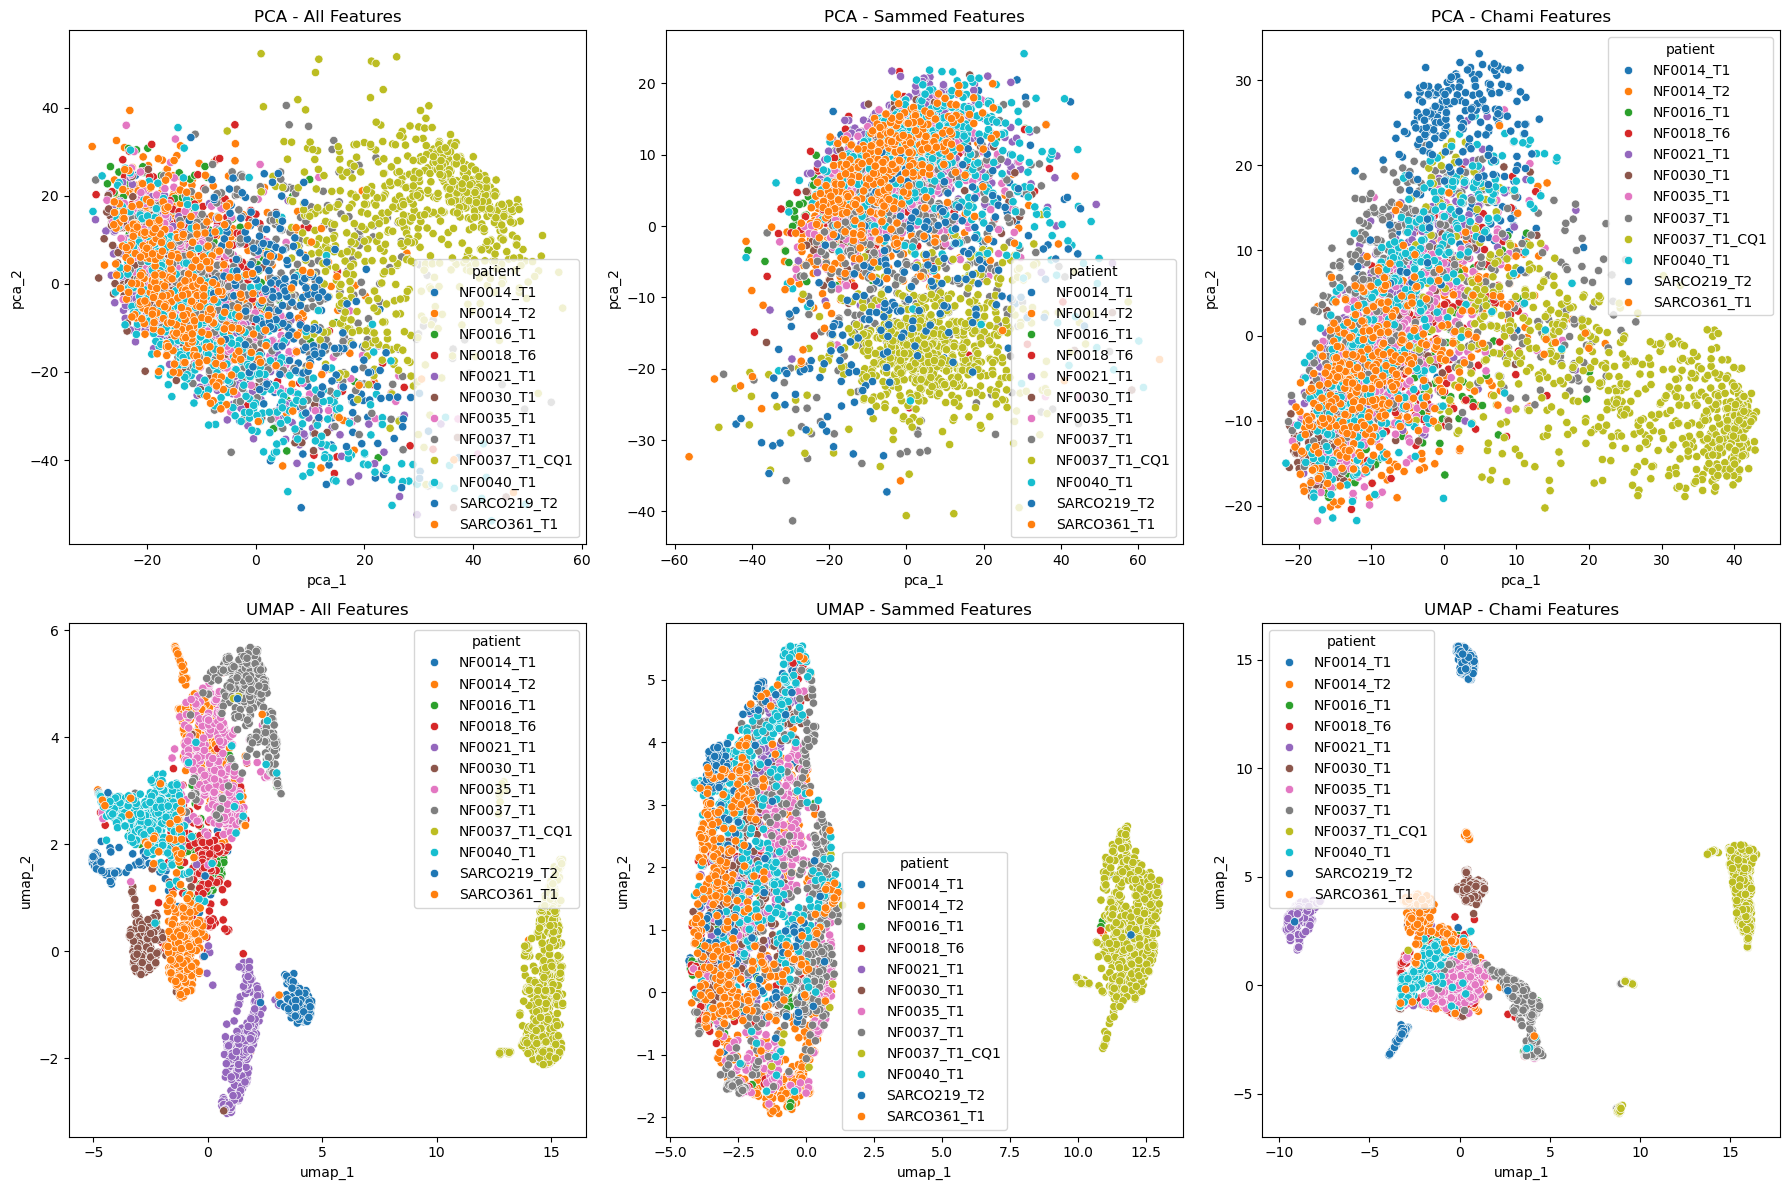

In [ ]:
# plot PCA and UMAP for both features
# row 1: PCA, row 2: UMAP
# column 1: all features, column 2: sammed features, column 3: chami features
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
sns.scatterplot(
    data=all_features_projection_df,
    x="pca_1",
    y="pca_2",
    hue="patient",
    ax=axes[0, 0],
    palette="tab10",
)
axes[0, 0].set_title("PCA - All Features")
sns.scatterplot(
    data=sammed_features_projection_df,
    x="pca_1",
    y="pca_2",
    hue="patient",
    ax=axes[0, 1],
    palette="tab10",
)
axes[0, 1].set_title("PCA - Sammed Features")
sns.scatterplot(
    data=chami_features_projection_df,
    x="pca_1",
    y="pca_2",
    hue="patient",
    ax=axes[0, 2],
    palette="tab10",
)
axes[0, 2].set_title("PCA - Chami Features")
sns.scatterplot(
    data=all_features_projection_df,
    x="umap_1",
    y="umap_2",
    hue="patient",
    ax=axes[1, 0],
    palette="tab10",
)
axes[1, 0].set_title("UMAP - All Features")
sns.scatterplot(
    data=sammed_features_projection_df,
    x="umap_1",
    y="umap_2",
    hue="patient",
    ax=axes[1, 1],
    palette="tab10",
)
axes[1, 1].set_title("UMAP - Sammed Features")
sns.scatterplot(
    data=chami_features_projection_df,
    x="umap_1",
    y="umap_2",
    hue="patient",
    ax=axes[1, 2],
    palette="tab10",
)
axes[1, 2].set_title("UMAP - Chami Features")
plt.tight_layout()
plt.show()

## Drop the CQ1 data

In [ ]:
df = df.loc[df["patient"] != "NF0037_T1_CQ1"]
feature_df = df.drop(columns=["patient", "well_fov"])
metadata_df = df[["patient", "well_fov"]]
sammed_features = df[[x for x in df.columns if "sammed" in x.lower()]]
chami_features = df[[x for x in df.columns if "chami" in x.lower()]]


all_features_projection_df = generate_umap_and_pca(feature_df, metadata_df.copy())
sammed_features_projection_df = generate_umap_and_pca(
    sammed_features, metadata_df.copy()
)
chami_features_projection_df = generate_umap_and_pca(chami_features, metadata_df.copy())

/home/lippincm/miniforge3/envs/nf1_image_based_profiling_env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/lippincm/miniforge3/envs/nf1_image_based_profiling_env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/lippincm/miniforge3/envs/nf1_image_based_profiling_env/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


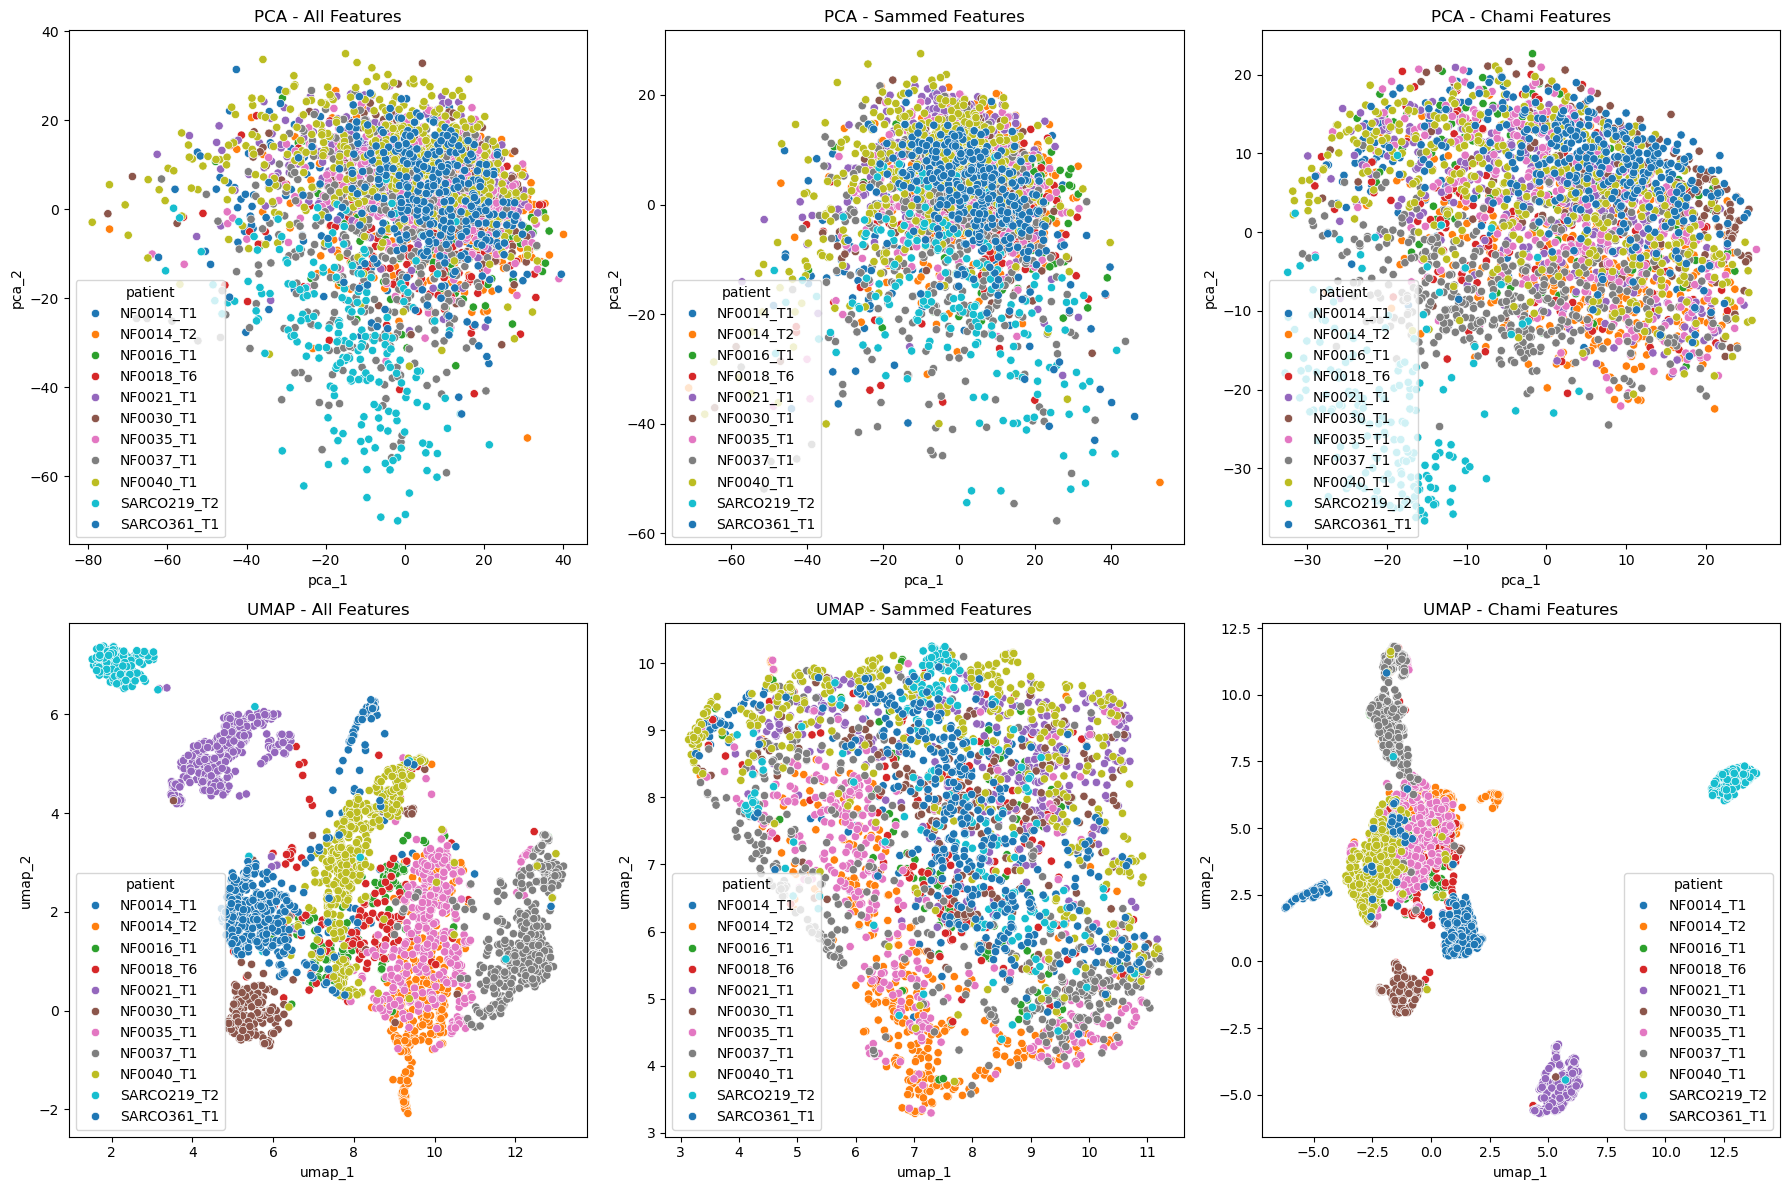

In [ ]:
# plot PCA and UMAP for both features
# row 1: PCA, row 2: UMAP
# column 1: all features, column 2: sammed features, column 3: chami features
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
sns.scatterplot(
    data=all_features_projection_df,
    x="pca_1",
    y="pca_2",
    hue="patient",
    ax=axes[0, 0],
    palette="tab10",
)
axes[0, 0].set_title("PCA - All Features")
sns.scatterplot(
    data=sammed_features_projection_df,
    x="pca_1",
    y="pca_2",
    hue="patient",
    ax=axes[0, 1],
    palette="tab10",
)
axes[0, 1].set_title("PCA - Sammed Features")
sns.scatterplot(
    data=chami_features_projection_df,
    x="pca_1",
    y="pca_2",
    hue="patient",
    ax=axes[0, 2],
    palette="tab10",
)
axes[0, 2].set_title("PCA - Chami Features")
sns.scatterplot(
    data=all_features_projection_df,
    x="umap_1",
    y="umap_2",
    hue="patient",
    ax=axes[1, 0],
    palette="tab10",
)
axes[1, 0].set_title("UMAP - All Features")
sns.scatterplot(
    data=sammed_features_projection_df,
    x="umap_1",
    y="umap_2",
    hue="patient",
    ax=axes[1, 1],
    palette="tab10",
)
axes[1, 1].set_title("UMAP - Sammed Features")
sns.scatterplot(
    data=chami_features_projection_df,
    x="umap_1",
    y="umap_2",
    hue="patient",
    ax=axes[1, 2],
    palette="tab10",
)
axes[1, 2].set_title("UMAP - Chami Features")
plt.tight_layout()
plt.show()